# Evaluate new polynomial solution

In [1]:
import funcs
from distortionMaps import d2cMapping

import numpy as np
from datetime import date
from astropy.io import fits
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [4]:
# directories

# USER:
user = "yannis" # "alvaro","yannis"
# Set work directory
if user == "alvaro":
    workDir = "./"
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"

datadir = "data/"
cdpDir = workDir+"cdp_data/"

# analysis inputs
band = "1B"
etal = "ET1A" # "ET1A", "ET1B", "ET2A", "ET2B"
islice = 6

# load new wavelength solution
wavsolution_file   = 'data/Band'+str(band)+'_ET'+ etal[-2:] +'_slice'+str(islice)+'_coeffs.txt'
slice_wavcoeffs = np.loadtxt(wavsolution_file,unpack=True, skiprows = 5)

In [5]:
slice_wavcoeffs

array([ 5.63010007e+00, -4.86241075e-05, -6.57954961e-08,  0.00000000e+00,
        0.00000000e+00,  1.12486237e-03,  5.26291487e-08,  1.28084254e-09,
        0.00000000e+00,  0.00000000e+00, -1.17516003e-07,  4.78831694e-12,
       -1.22235984e-12,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [12]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir,fileversion='7B.05.01')
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

# compute slice reference x-position
alpha_img = np.zeros(det_dims)
alpha_img[(sliceMap == 100*int(band[0])+islice)] = alphaMap[(sliceMap == 100*int(band[0])+islice)]
x_coords = np.nonzero(alpha_img[512,:])[0]
alphas = alpha_img[512,:][x_coords]
xs = interp1d(alphas,x_coords)(0.)

In [13]:
fileversion = "7B.05.01"
distcdp = {}
distcdp["3C"] = "MIRI_FM_MIRIFULONG_34LONG_DISTORTION_%s.fits" %fileversion
distcdp["3B"] = "MIRI_FM_MIRIFULONG_34MEDIUM_DISTORTION_%s.fits" %fileversion
distcdp["3A"] = "MIRI_FM_MIRIFULONG_34SHORT_DISTORTION_%s.fits" %fileversion

distcdp["1C"] = "MIRI_FM_MIRIFUSHORT_12LONG_DISTORTION_%s.fits" %fileversion
distcdp["1B"] = "MIRI_FM_MIRIFUSHORT_12MEDIUM_DISTORTION_%s.fits" %fileversion
distcdp["1A"] = "MIRI_FM_MIRIFUSHORT_12SHORT_DISTORTION_%s.fits" %fileversion

distcdp["4C"] = distcdp["3C"]
distcdp["4B"] = distcdp["3B"]
distcdp["4A"] = distcdp["3A"]

distcdp["2C"] = distcdp["1C"]
distcdp["2B"] = distcdp["1B"]
distcdp["2A"] = distcdp["1A"]

In [14]:
band_distCDP = fits.open(cdpDir+distcdp[band])
slice_wavcoeffs_cdp = np.array(band_distCDP['Lambda_CH{}'.format(band[0])].data[islice-1])

In [15]:
print '------DISTORTION CDP version {}--------'.format(fileversion)
print 'Reference x-position: {}pix'.format(round(slice_wavcoeffs_cdp[0],2))
print '2D polynomial coefficients: {}'.format(slice_wavcoeffs_cdp[1:])
print ''
print '------NEW WAVECAL--------'
print 'Reference x-position: {}pix'.format(round(xs,2))
print '2D polynomial coefficients: {}'.format(slice_wavcoeffs)

------DISTORTION CDP version 7B.05.01--------
Reference x-position: 569.47pix
2D polynomial coefficients: [ 1.80741346e+01  4.85391777e-04 -1.96210618e-06  1.59627900e-08
  1.82015631e-10 -2.39042508e-03  2.31072742e-08  5.23382289e-11
 -7.53809970e-11 -4.08594108e-13 -2.30049415e-07 -3.61358588e-10
  3.21392099e-12  1.59691975e-13 -1.42279376e-17 -1.73521765e-12
  1.14947652e-13 -2.36828174e-15 -1.26128440e-16 -4.00604628e-20
 -1.59091891e-14  9.24405743e-18  4.15986705e-19  1.88408007e-20
  1.32926125e-22]

------NEW WAVECAL--------
Reference x-position: 573.25pix
2D polynomial coefficients: [ 1.80720334e+01  2.85657975e-04 -1.12287891e-06  0.00000000e+00
  0.00000000e+00 -2.35712153e-03 -1.08312576e-07  1.00656176e-08
  0.00000000e+00  0.00000000e+00 -2.68522569e-07  5.10463382e-11
 -8.67358403e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000

In [20]:
channel = int(band[0])
new_lambdaMap  = np.zeros(sliceMap.shape)

for islice in range(1,nslices+1):
    # load new wavelength solution
    wavsolution_file   = 'data/Band'+str(band)+'_ET'+ etal[-2:] +'_slice'+str(islice)+'_coeffs.txt'
    slice_wavcoeffs = np.loadtxt(wavsolution_file,unpack=True,skiprows = 5)
    
    # create placeholder and identify pixels in slice
    pixelCtry,pixelCtrx = np.where(sliceMap == int(islice+100*channel))
    
    # apply the 2D polynomial transform
    lp = slice_wavcoeffs
    # compute slice reference x-position
    alpha_img = np.zeros(det_dims)
    alpha_img[(sliceMap == 100*int(band[0])+islice)] = alphaMap[(sliceMap == 100*int(band[0])+islice)]
    x_coords = np.nonzero(alpha_img[512,:])[0]
    alphas = alpha_img[512,:][x_coords]
    xs = interp1d(alphas,x_coords)(0.)
    
    new_lambdaMap[pixelCtry,pixelCtrx]   = funcs.polyval2d(xs,pixelCtrx, pixelCtry, lp)

<IPython.core.display.Javascript object>


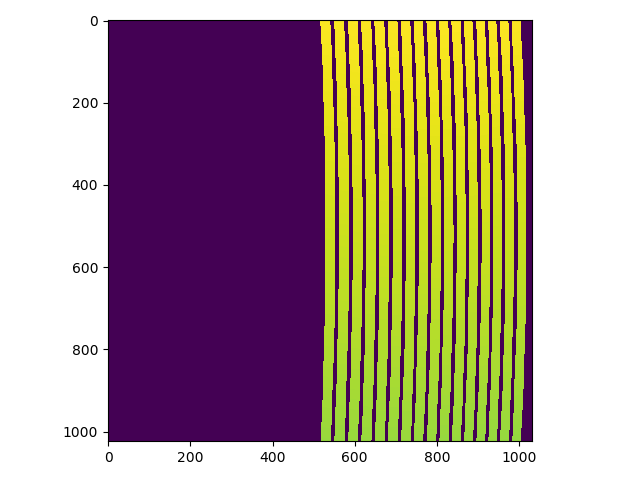

<IPython.core.display.Javascript object>


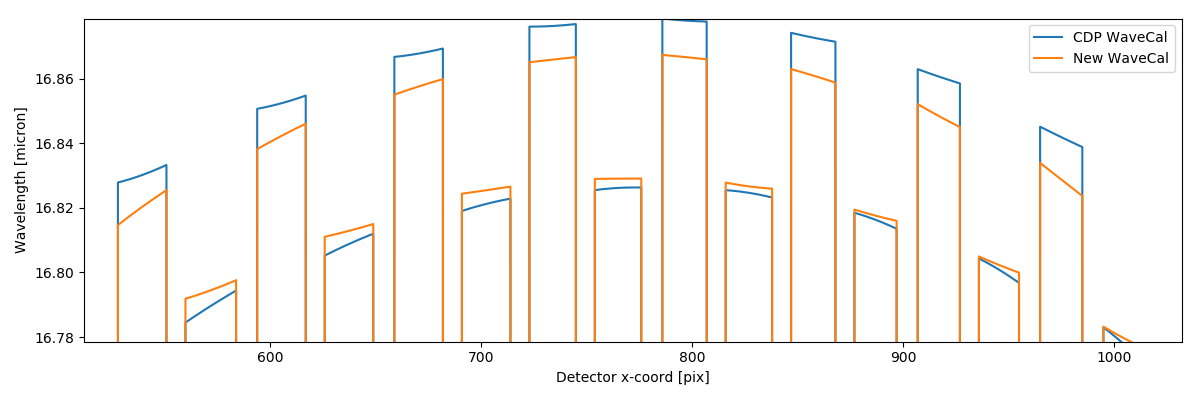

<IPython.core.display.Javascript object>


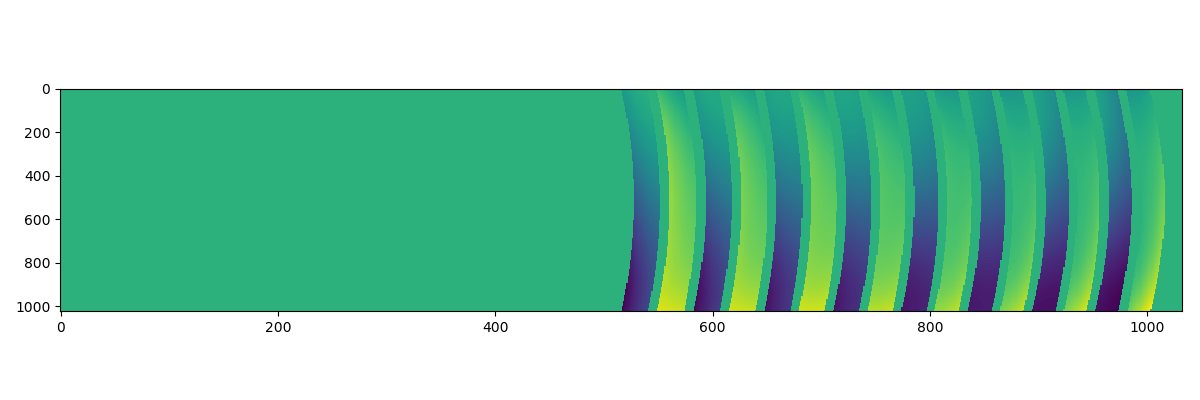

In [21]:
plt.figure()
plt.imshow(new_lambdaMap)
plt.tight_layout()

row = 512
plt.figure(figsize=(12,4))
if band[0] in ['1','4']:
    plt.plot(lambdaMap[row,:],label='CDP WaveCal')
    plt.plot(new_lambdaMap[row,:],label='New WaveCal')
    plt.xlim(0,512)
    plt.ylim(lambdaMap[row,:512].max()-0.1,lambdaMap[row,:512].max())
elif band[0] in ['2','3']:
    plt.plot(lambdaMap[row,:],label='CDP WaveCal')
    plt.plot(new_lambdaMap[row,:],label='New WaveCal')
    plt.xlim(512,1032)
    plt.ylim(lambdaMap[row,512:].max()-0.1,lambdaMap[row,512:].max())
plt.xlabel('Detector x-coord [pix]')
plt.ylabel('Wavelength [micron]')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.imshow(new_lambdaMap-lambdaMap,aspect=0.2)
plt.tight_layout()

<IPython.core.display.Javascript object>


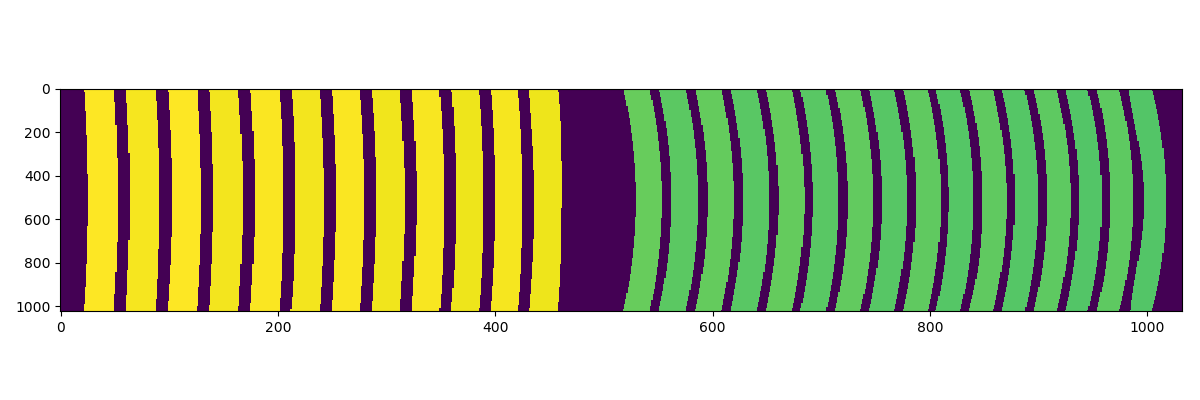

In [18]:
plt.figure(figsize=(12,4))
plt.imshow(sliceMap,aspect=0.2)
plt.tight_layout()